# Import Library

In [ ]:
# Data Processing & Feature Engineering
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Tree-based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep Learning (RNN, LSTM) - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Custom Modules
from data_preprocessing import process_data

# Function Library

In [2]:
def evaluate_model(X_test, y_test, model_name, model=None, y_pred= None):
    if y_pred is not None:
        y_pred = y_pred
    else:
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Performance Metrics:")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.4%}")
    print(f"R² Score: {r2:.4f}")
    
    return y_pred, mae, rmse, mape, r2

def plot_residuals(y_pred, y_test, model_name):
    resids = y_test - y_pred

    fig, ax = plt.subplots(1,2, figsize= (20, 6))

    sns.histplot(resids, kde= True, color= 'skyblue', ax= ax[0])
    ax[0].set_title(f"{model_name}: Residuals Distribution", fontsize= 14, fontweight= 'bold')
    ax[0].set_xlabel("Residual Value", fontweight= 'bold')
    ax[0].set_ylabel("Frequency", fontweight= 'bold')

    sns.scatterplot(x= y_test, y= y_pred, alpha= 0.4, ax= ax[1])
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw= 2)
    ax[1].set_title(f"{model_name}: Actual vs. Predicted Flight Prices", fontsize= 14, fontweight= 'bold')
    ax[1].set_xlabel('Actual Flight Price', fontweight= 'bold')
    ax[1].set_ylabel('Predicted Flight Price', fontweight= 'bold')
    

    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importances, features, model_name):
    data= pd.DataFrame({'features': features, 'feature_importance': feature_importances})
    data = data.sort_values(by=['feature_importance'], ascending=False)

    plt.figure(figsize=(10,8))
    sns.barplot(x= data['feature_importance'], y= data['features'])
    plt.title(f"{model_name} Feature Importance", fontsize= 14, fontweight= 'bold')
    plt.xlabel('Feature Importance', fontweight= 'bold')
    plt.ylabel('Feature', fontweight= 'bold')

def create_sequences_by_group(df, sequence_length):
    X_seq_list = []
    y_seq_list = []

    groups = df.groupby(['flightDate', 'startingAirport', 'destinationAirport'])

    for group_keys, group_df in groups:
        # Sort the group by daysToDeparture
        group_df = group_df.sort_values("daysToDeparture")

        # Only build a sequence if the group is large enough.
        if len(group_df) <= sequence_length:
            continue

        # Drop columns that are used for grouping (keep flight date for reference)
        X_group = group_df.drop(columns=['totalFare', 'flightDate', 'startingAirport', 'destinationAirport'])

        # Dropping Bugged columns for now:
        X_group = X_group.drop(columns=['airlineCode', 'cabinClass'])

        y_group = group_df['totalFare']

        # Ensure the feature data is numeric (convert booleans to float, etc.)
        X_group = X_group.astype('float32')

        X_values = X_group.to_numpy()
        y_values = y_group.to_numpy().reshape(-1, 1)

        for i in range(len(X_values) - sequence_length):
            X_seq_list.append(X_values[i:i+sequence_length])
            y_seq_list.append(y_values[i + sequence_length])

    return np.array(X_seq_list), np.array(y_seq_list)

def plot_metrics(df, metrics, labels):
    fig, ax = plt.subplots(2, 2, figsize= (10, 12))
    ax = ax.flatten()
    
    x = df['Model']
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        y = df[metric]
        colors = ["green" if val == y.min() else "blue" for val in y]

        ax[i].bar(x, y, color=colors)
        ax[i].set_xlabel("Model", fontsize=10)
        ax[i].set_ylabel(label, fontsize=10)
        ax[i].set_xticklabels(x, rotation=90)
        ax[i].set_title(f"{label} by Model", fontsize=12, fontweight="bold")

        if metric == 'MAE':
            ax[i].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'${y:,.0f}'))
    
    plt.tight_layout()
    plt.show()


# Data Preprocessing

## Data Loading & Feature Engineering

In [ ]:
df = process_data()
df.head()

,flightDate,startingAirport,destinationAirport,travelDuration,isRefundable,isNonStop,totalFare,seatsRemaining,airlineCode,cabinClass,...,isHoliday,nearHoliday,price_t_minus_1,price_t_minus_2,price_t_minus_3,price_t_minus_4,price_t_minus_5,price_t_minus_6,price_t_minus_7,price_t_plus_1
0,2022-08-29,1,4,421,False,False,327.60,9,83,15,...,False,False,318.60,218.2,327.60,327.60,327.60,318.60,327.60,208.2
1,2022-07-11,4,5,788,False,False,218.58,0,110,15,...,False,False,218.58,468.6,357.19,278.60,178.58,177.61,468.60,228.6
2,2022-09-21,2,11,579,False,False,235.69,9,83,0,...,False,False,605.11,406.1,605.11,605.11,400.10,605.11,605.11,400.1
3,2022-10-25,2,1,284,False,False,119.10,7,34,0,...,False,False,340.10,340.1,287.10,119.10,119.10,340.10,340.10,119.1
4,2022-07-06,1,4,406,False,False,331.60,7,34,15,...,False,True,244.60,331.6,331.60,331.60,302.20,244.60,331.60,331.6


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759691 entries, 0 to 759690
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   startingAirport     759691 non-null  int64  
 1   destinationAirport  759691 non-null  int64  
 2   travelDuration      759691 non-null  int64  
 3   isRefundable        759691 non-null  bool   
 4   isNonStop           759691 non-null  bool   
 5   totalFare           759691 non-null  float64
 6   seatsRemaining      759691 non-null  int64  
 7   airlineCode         759691 non-null  int64  
 8   cabinClass          759691 non-null  int64  
 9   travelDistance      759691 non-null  float64
 10  departureTimeHour   759691 non-null  int64  
 11  daysToDeparture     759691 non-null  int64  
 12  departureDayOfWeek  759691 non-null  int64  
 13  isWeekend           759691 non-null  bool   
 14  isHoliday           759691 non-null  bool   
 15  nearHoliday         759691 non-nul

## Train/Test Splitting

In [ ]:
# Our X variables in these models will be all columns that are not price
X = df.drop(columns= ['price_t_plus_1', 'flightDate'], axis= 1)

# Our y variable is of course price which is called 'totalFare'
y = df['price_t_plus_1']

# Split the data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [19]:
# Smaller sample for hyperparameter tuning to save time
sample_indices = np.random.choice(len(X_train), min(100000, len(X_train)), replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]
print(f"Using {len(X_train_sample)} samples for hyperparameter tuning")

Using 100000 samples for hyperparameter tuning


# Tree Modeling

## Decision Tree

### Hyperparameter Tuning

In [20]:
# Decision Tree Hyperparameter Tuning
print("--- Decision Tree Hyperparameter Tuning ---")
dt_param_grid = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state= 42),
    param_grid=dt_param_grid,
    cv= 3,
    scoring= 'neg_mean_absolute_error',
    n_jobs= -1,
    verbose= 1
)

print("Training Decision Tree models...")
dt_grid.fit(X_train_sample, y_train_sample)

print("\nBest Decision Tree parameters:")
print(dt_grid.best_params_)
print(f"Best CV score: {-dt_grid.best_score_:.2f} MAE")


--- Decision Tree Hyperparameter Tuning ---
Training Decision Tree models...
Fitting 3 folds for each of 240 candidates, totalling 720 fits

Best Decision Tree parameters:
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best CV score: 67.94 MAE


### Fit & Evaluation

In [21]:
# Running the model with the best parameters on the whole dataset
dt = DecisionTreeRegressor(**dt_grid.best_params_, random_state=42)
dt.fit(X_train, y_train)
dt_y_pred, dt_mae, dt_rmse, dt_mape, dt_r2 = evaluate_model(X_test, y_test, "Decision Tree", model= dt)

# Saving the model results 
dt_metrics = {
    "Model": "Decision Tree",
    "MAE": dt_mae,
    "RMSE": dt_rmse,
    "MAPE": dt_mape,
    "R²": dt_r2
}

Decision Tree Performance Metrics:
Mean Absolute Error: 64.5127
Root Mean Squared Error: 114.2089
Mean Absolute Percentage Error: 23.0578%
R² Score: 0.6556


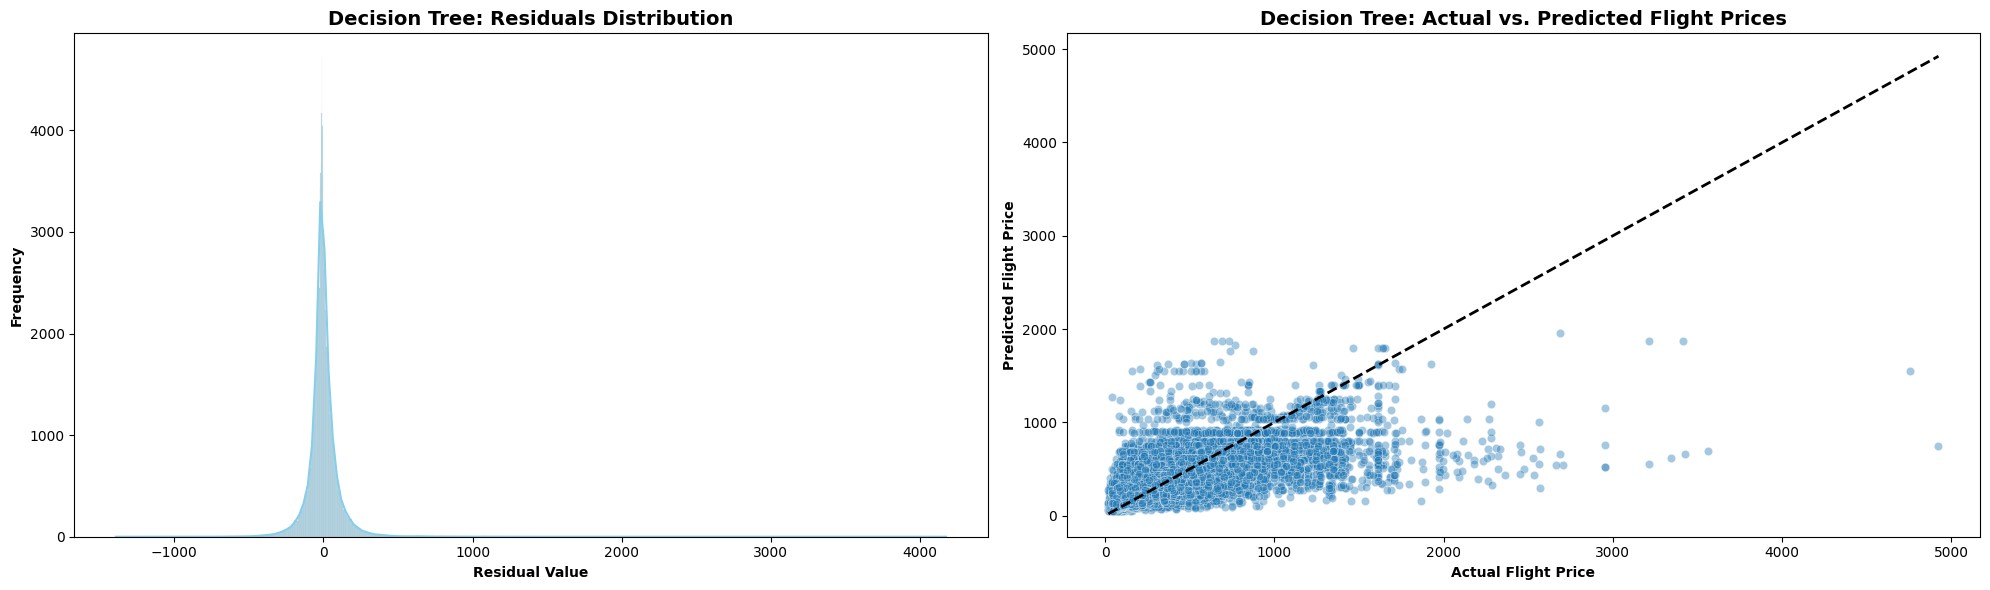

In [22]:
plot_residuals(dt_y_pred, y_test, "Decision Tree")

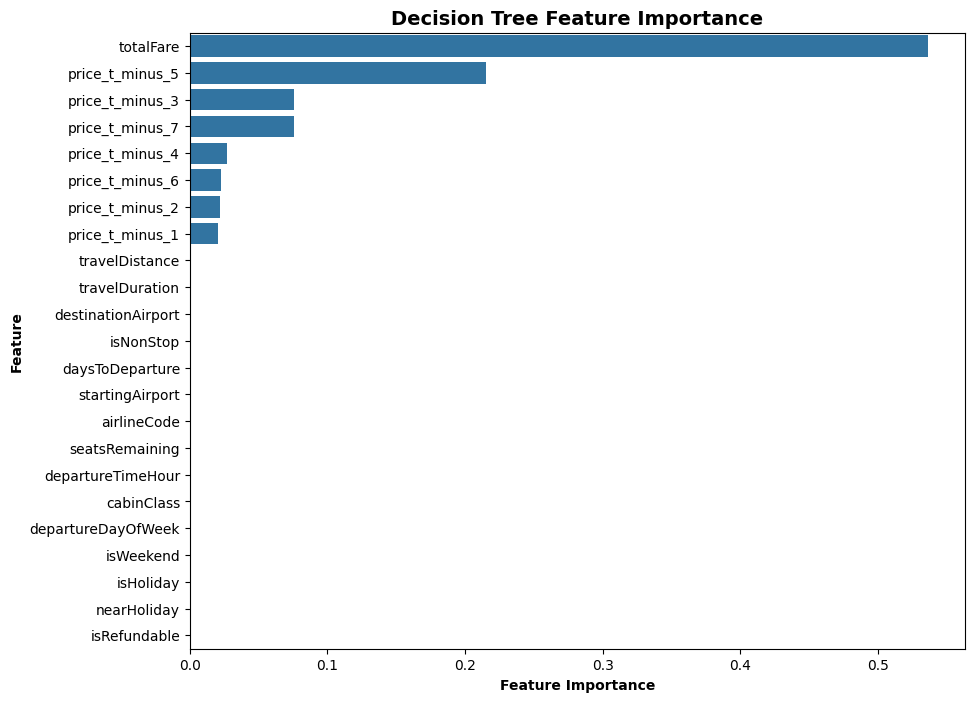

In [30]:
plot_feature_importance(dt.feature_importances_, X_train.columns, "Decision Tree")

## Random Forest

### Hyperparameter Tuning

In [31]:
# Random Forest Hyperparameter Tuning
print("--- Random Forest Hyperparameter Tuning ---")
rf_param_grid = {
    'n_estimators': [150, 200, 300],  
    'max_depth': [22, 23, 24, 25], 
    'min_samples_split': [5, 10, 15],  
    'min_samples_leaf': [2, 4, 6],  
    'max_features': ['sqrt'],  
    'bootstrap': [False, True]  
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state= 42, n_jobs= -1),
    param_grid= rf_param_grid,
    cv= 3,
    scoring= 'neg_mean_absolute_error',
    n_jobs= -1,
    verbose= 1
)

print("Training Random Forest models...")
rf_grid.fit(X_train_sample, y_train_sample)

print("\nBest Random Forest parameters:")
print(rf_grid.best_params_)
print(f"Best CV score: {-rf_grid.best_score_:.2f} MAE")

--- Random Forest Hyperparameter Tuning ---
Training Random Forest models...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best Random Forest parameters:
{'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: 62.88 MAE


### Fit & Evaluation

In [33]:
# Running the model with the best parameters on the whole dataset
rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred, rf_mae, rf_rmse, rf_mape, rf_r2 = evaluate_model(X_test, y_test, "Random Forest", model= rf)

# Saving the model results 
rf_metrics = {
    "Model": "Random Forest",
    "MAE": rf_mae,
    "RMSE": rf_rmse,
    "MAPE": rf_mape,
    "R²": rf_r2
}

Random Forest Performance Metrics:
Mean Absolute Error: 58.6432
Root Mean Squared Error: 105.0510
Mean Absolute Percentage Error: 20.6098%
R² Score: 0.7086


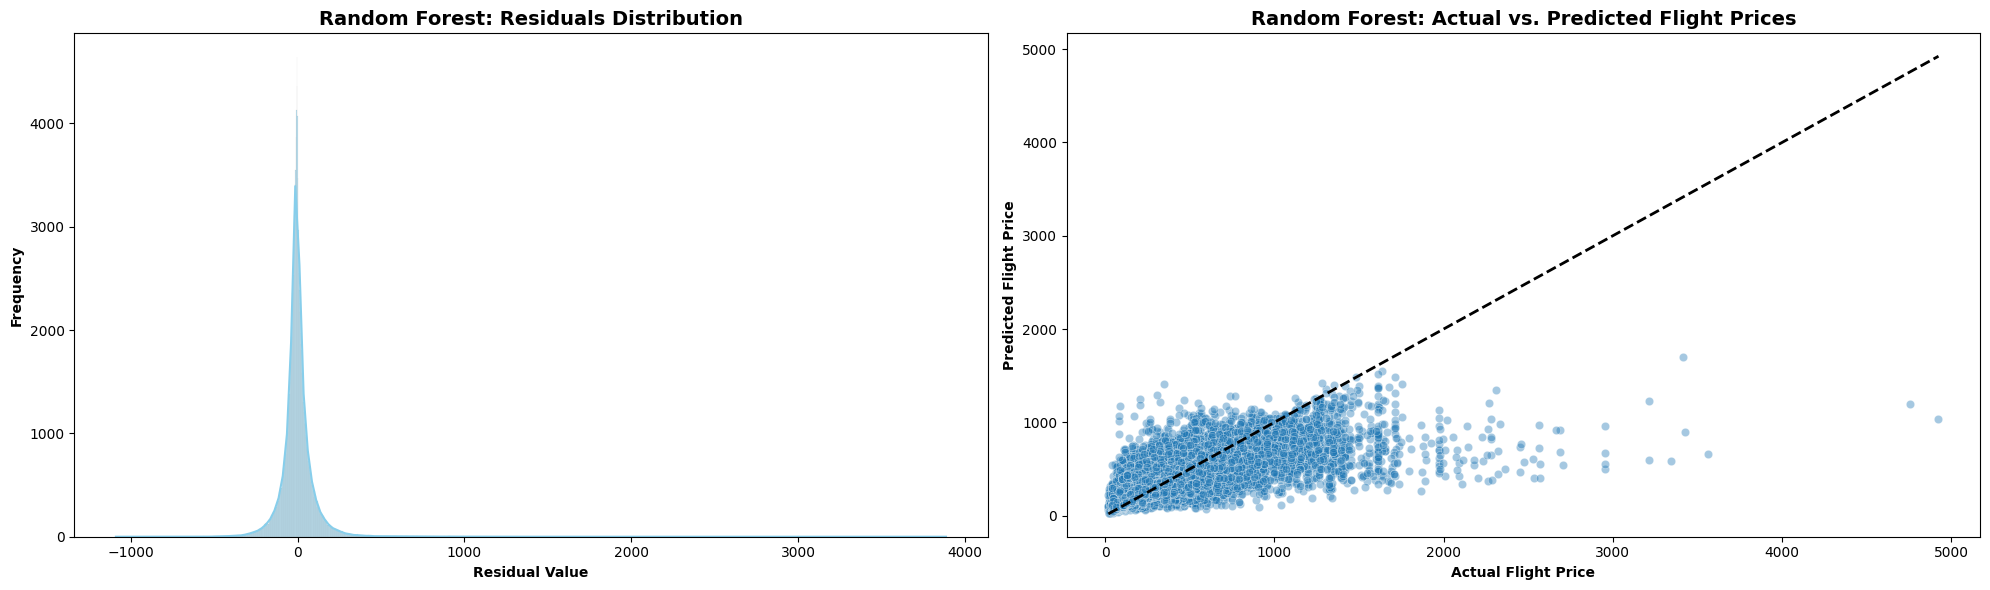

In [34]:
# Examine Residuals
plot_residuals(rf_y_pred, y_test, "Random Forest")

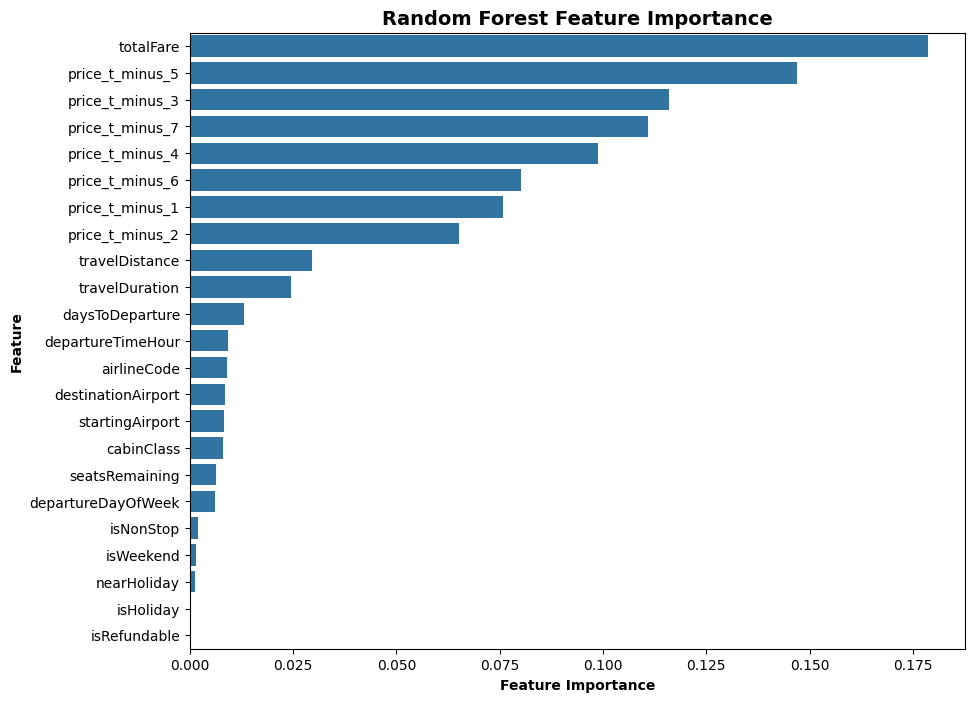

In [35]:
plot_feature_importance(rf.feature_importances_, X_train.columns, "Random Forest")

## XG Boost

### Hyperparameter Tuning

In [25]:
print("--- XGBoost Hyperparameter Tuning ---")
xgb_param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [6, 12, 18],  
    'learning_rate': [0.05, 0.1],  
    'colsample_bytree': [0.8, 1.0],  
    'min_child_weight': [1, 3],  
    'gamma': [0, 0.1]  
}

xgb_grid = GridSearchCV(
    XGBRegressor(random_state= 42, n_jobs= -1, enable_categorical= True),
    param_grid= xgb_param_grid,
    cv= 3,
    scoring= 'neg_mean_absolute_error',
    n_jobs= -1,
    verbose= 1
)

print("Training XGBoost models...")
xgb_grid.fit(X_train_sample, y_train_sample)

print("Best XGBoost parameters:")
print(xgb_grid.best_params_)
print(f"Best CV score: {-xgb_grid.best_score_:.4f} RMSE")

--- XGBoost Hyperparameter Tuning ---
Training XGBoost models...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best XGBoost parameters:
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 200}
Best CV score: 61.0053 RMSE


### Fit & Evaluation

In [26]:
# Running the model with the best parameters on the whole dataset
xgb = XGBRegressor(**xgb_grid.best_params_, random_state= 42, enable_categorical= True)
xgb.fit(X_train, y_train)  
xgb_y_pred, xgb_mae, xgb_rmse, xgb_mape, xgb_r2 = evaluate_model(X_test, y_test, "XG Boost", model= xgb)

# Saving the model results 
xgb_metrics = {
    "Model": "XG Boost",
    "MAE": xgb_mae,
    "RMSE": xgb_rmse,
    "MAPE": xgb_mape,
    "R²": xgb_r2
}

XG Boost Performance Metrics:
Mean Absolute Error: 56.7954
Root Mean Squared Error: 104.4883
Mean Absolute Percentage Error: 19.7109%
R² Score: 0.7117


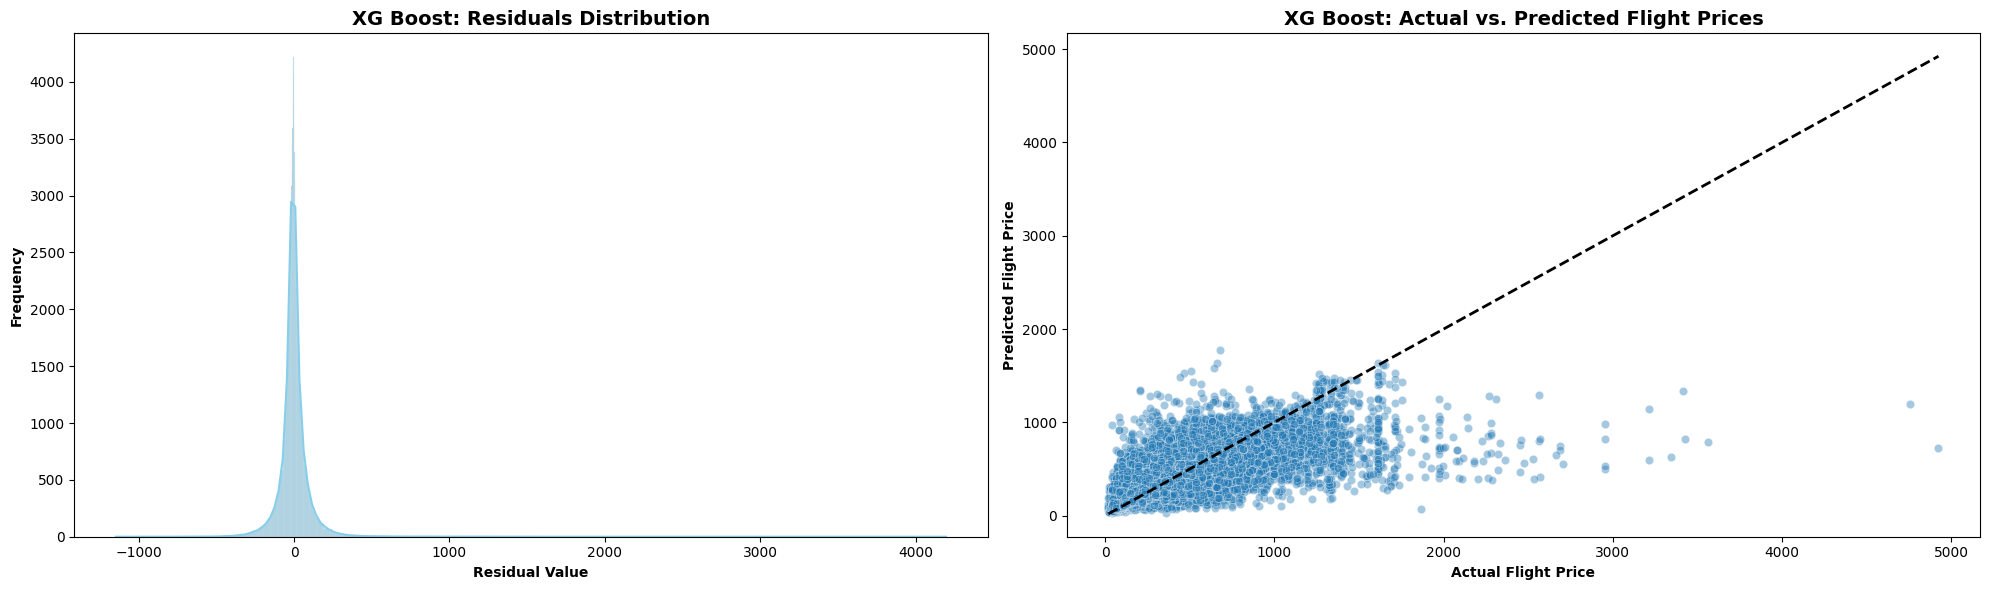

In [27]:
plot_residuals(xgb_y_pred, y_test, "XG Boost")

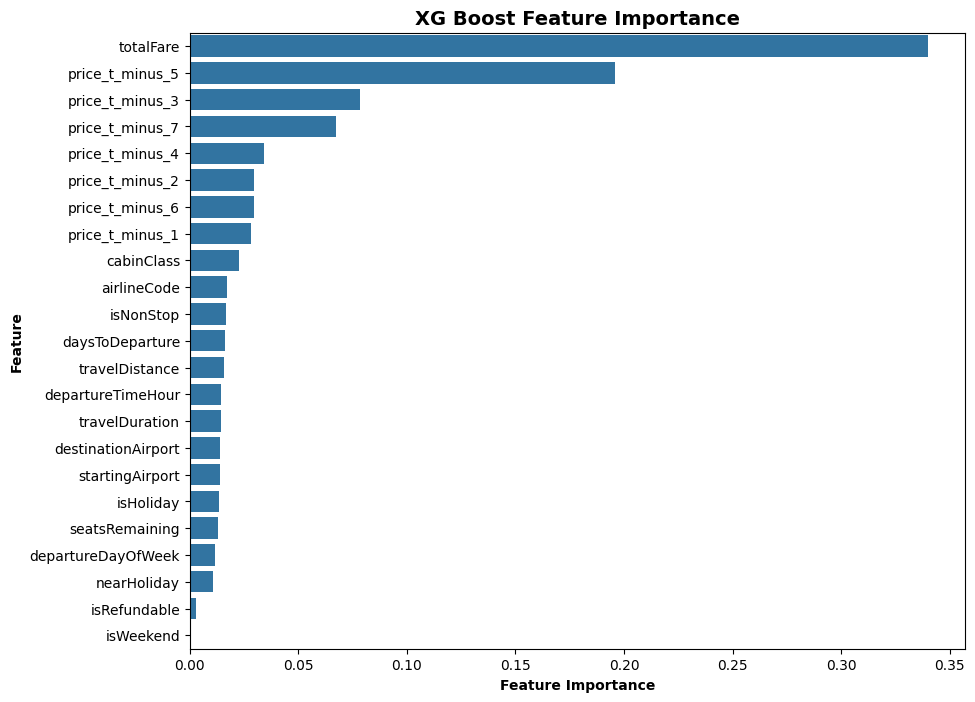

In [28]:
plot_feature_importance(xgb.feature_importances_, X_train.columns, "XG Boost")

# Temporal Deep Learning Models

## Adjusted Data Preprocessing

In [52]:
# Our X variables in these models will be all columns that are not price
X = df.drop(columns= ['price_t_plus_1'], axis= 1)

# Our y variable is of course price which is called 'totalFare'
y = df['price_t_plus_1']

# Split the data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [54]:
X

,flightDate,startingAirport,destinationAirport,travelDuration,isRefundable,isNonStop,totalFare,seatsRemaining,airlineCode,cabinClass,...,isWeekend,isHoliday,nearHoliday,price_t_minus_1,price_t_minus_2,price_t_minus_3,price_t_minus_4,price_t_minus_5,price_t_minus_6,price_t_minus_7
0,2022-08-29,1,4,421,False,False,327.60,9,83,15,...,False,False,False,318.60,218.2,327.60,327.60,327.60,318.60,327.60
1,2022-07-11,4,5,788,False,False,218.58,0,110,15,...,False,False,False,218.58,468.6,357.19,278.60,178.58,177.61,468.60
2,2022-09-21,2,11,579,False,False,235.69,9,83,0,...,False,False,False,605.11,406.1,605.11,605.11,400.10,605.11,605.11
3,2022-10-25,2,1,284,False,False,119.10,7,34,0,...,False,False,False,340.10,340.1,287.10,119.10,119.10,340.10,340.10
4,2022-07-06,1,4,406,False,False,331.60,7,34,15,...,False,False,True,244.60,331.6,331.60,331.60,302.20,244.60,331.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759686,2022-08-17,2,1,484,False,False,380.40,1,30,18,...,False,False,False,106.10,380.4,380.40,126.10,106.10,380.40,106.10
759687,2022-08-02,10,3,256,False,True,280.10,1,29,42,...,False,False,False,272.60,228.6,370.60,369.10,347.20,312.60,312.60
759688,2022-09-12,6,5,118,False,True,118.60,9,70,0,...,False,False,False,118.60,118.6,118.60,118.60,118.60,118.60,118.60
759689,2022-08-27,7,13,242,False,False,191.10,7,34,0,...,True,False,False,183.60,192.6,192.60,192.60,192.60,191.10,191.10


In [53]:
sequence_length = 60
df = df.fillna(0)
X_sequences, y_sequences = create_sequences_by_group(df, sequence_length)

print("X_sequences shape:", X_sequences.shape)  # (num_sequences, sequence_length, num_features)
print("y_sequences shape:", y_sequences.shape)

X_sequences shape: (118, 60, 19)
y_sequences shape: (118, 1)


### Adjusted Train/Test Splitting

In [55]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequences, 
    y_sequences, 
    test_size= 0.2, 
    random_state= 42
)

num_features = X_train_seq.shape[2]

In [56]:
scaler_X = MinMaxScaler()
X_train_seq_flat = X_train_seq.reshape(-1, num_features)
scaler_X.fit(X_train_seq_flat)
X_train_seq_scaled = scaler_X.transform(X_train_seq_flat).reshape(X_train_seq.shape)

X_test_seq_flat = X_test_seq.reshape(-1, num_features)
X_test_seq_scaled = scaler_X.transform(X_test_seq_flat).reshape(X_test_seq.shape)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_seq)
y_train_seq_scaled = scaler_y.transform(y_train_seq)
y_test_seq_scaled = scaler_y.transform(y_test_seq)

print("NaNs in X_train_seq_scaled:", np.isnan(X_train_seq_scaled).sum())
print("NaNs in y_train_seq_scaled:", np.isnan(y_train_seq_scaled).sum())

NaNs in X_train_seq_scaled: 0
NaNs in y_train_seq_scaled: 0


In [57]:
mps_devices = tf.config.list_physical_devices('MPS')
if mps_devices:
    print("Using MPS device")
    device_name = '/device:MPS:0'
else:
    print("MPS device not found, using CPU/GPU")
    device_name = '/device:CPU:0'

MPS device not found, using CPU/GPU


## Recurrent Neural Network

### Learning

In [58]:
with tf.device(device_name):
    rnn_model = Sequential([
        SimpleRNN(50, activation= 'tanh', input_shape= (sequence_length, num_features)),
        Dense(1)  # Regression output for totalFare
    ])
    rnn_model.compile(optimizer= 'adam', loss= 'mse', metrics= ['mae'])
    print("RNN Model Summary:")
    rnn_model.summary()

    history_rnn = rnn_model.fit(
        X_train_seq_scaled, y_train_seq_scaled,
        epochs= 50, 
        batch_size= 32,
        validation_data= (X_test_seq_scaled, y_test_seq_scaled)
    )

RNN Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.1454 - mae: 0.2882 - val_loss: 0.1783 - val_mae: 0.3736
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1206 - mae: 0.2674 - val_loss: 0.1221 - val_mae: 0.3067
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0692 - mae: 0.2084 - val_loss: 0.0905 - val_mae: 0.2481
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0601 - mae: 0.1916 - val_loss: 0.0807 - val_mae: 0.2343
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0615 - mae: 0.1938 - val_loss: 0.0776 - val_mae: 0.2379
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0419 - mae: 0.1721 - val_loss: 0.0854 - val_mae: 0.2440
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0391 - mae: 0.1689 - val_loss: 0.0715 - val_mae: 0.2225
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0349 - mae: 0.1527 - val_loss: 0.0612 - val_mae: 0.2016
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0313 - mae: 0.1423 - 

### Evaluation

In [59]:
rnn_y_pred_scaled = rnn_model.predict(X_test_seq_scaled)
rnn_y_pred = scaler_y.inverse_transform(rnn_y_pred_scaled)
rnn_y_test = scaler_y.inverse_transform(y_test_seq_scaled)

rnn_y_pred, rnn_mae, rnn_rmse, rnn_mape, rnn_r2 = evaluate_model(
    X_test, 
    rnn_y_test, 
    "Recurrent Neural Network", 
    model= None, 
    y_pred= rnn_y_pred
)

# Saving the model results 
rnn_metrics = {
    "Model": "Recurrent Neural Network",
    "MAE": rnn_mae,
    "RMSE": rnn_rmse,
    "MAPE": rnn_mape,
    "R²": rnn_r2
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Recurrent Neural Network Performance Metrics:
Mean Absolute Error: 122.3362
Root Mean Squared Error: 154.2471
Mean Absolute Percentage Error: 49.1181%
R² Score: -1.6036


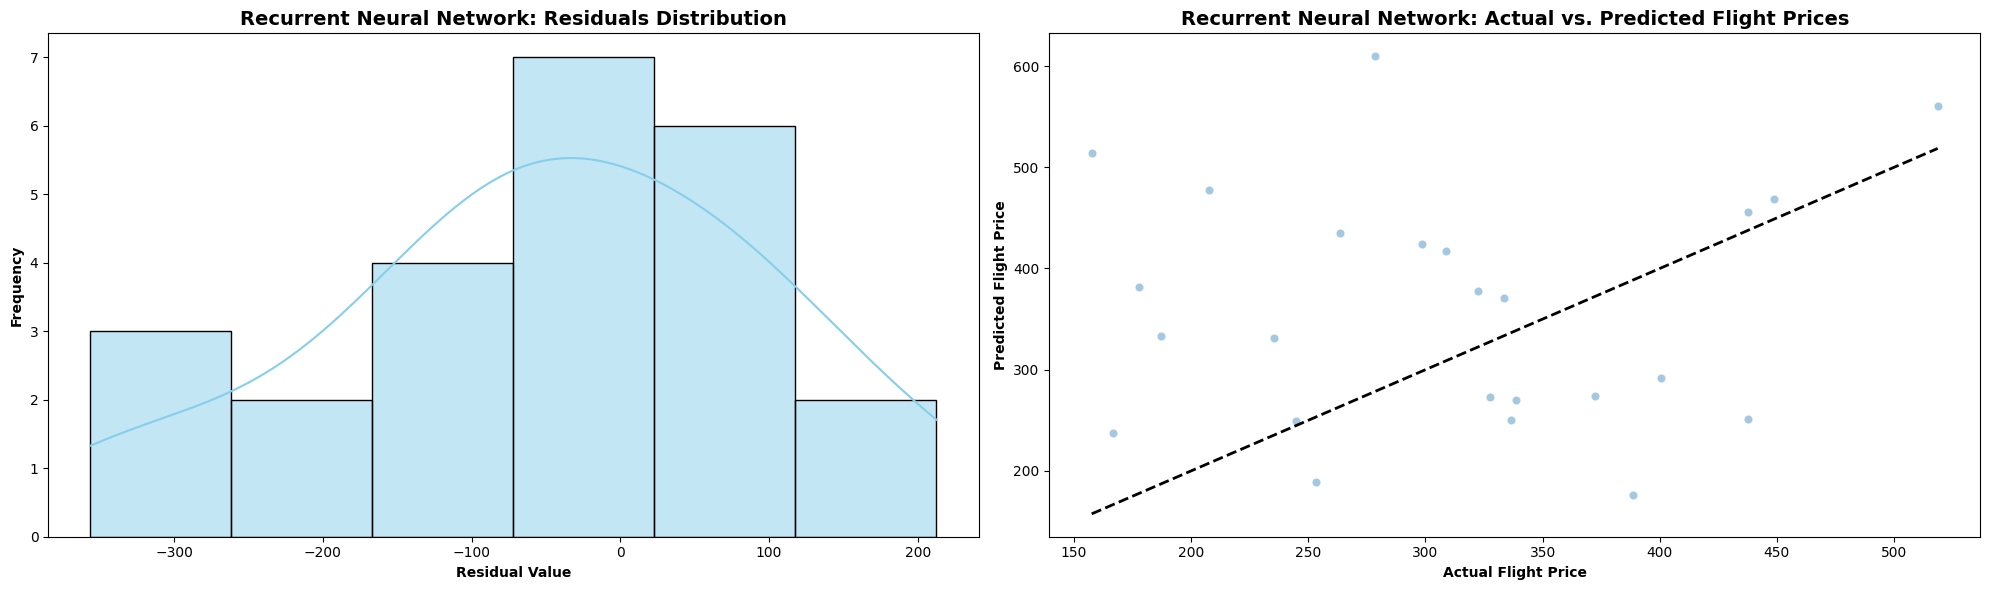

In [60]:
plot_residuals(rnn_y_pred.flatten(), rnn_y_test.flatten(), "Recurrent Neural Network")

## Long Short-Term Memory

### Learning

In [150]:
with tf.device(device_name):
    lstm_model = Sequential([
        LSTM(50, activation='tanh', input_shape= (sequence_length, num_features)),
        Dense(1)
    ])
    lstm_model.compile(optimizer= 'adam', loss= 'mse', metrics= ['mae'])
    print("LSTM Model Summary:")
    lstm_model.summary()

    history_lstm = lstm_model.fit(
        X_train_seq_scaled, 
        y_train_seq_scaled,
        epochs= 5, 
        batch_size= 32,
        validation_data= (X_test_seq_scaled, y_test_seq_scaled)
    )

LSTM Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0037 - mae: 0.0359 - val_loss: 0.0028 - val_mae: 0.0295
Epoch 2/5
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0031 - mae: 0.0321 - val_loss: 0.0028 - val_mae: 0.0295
Epoch 3/5
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0029 - mae: 0.0310 - val_loss: 0.0027 - val_mae: 0.0301
Epoch 4/5
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0030 - mae: 0.0308 - val_loss: 0.0027 - val_mae: 0.0288
Epoch 5/5
4660/4660 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0028 - mae: 0.0301 - val_loss: 0.0027 - val_mae: 0.0296


### Evaluation

In [151]:
# Predict and reverse the scaling for evaluation
lstm_y_pred_scaled = lstm_model.predict(X_test_seq_scaled)
lstm_y_pred = scaler_y.inverse_transform(lstm_y_pred_scaled)
lstm_y_test = scaler_y.inverse_transform(y_test_seq_scaled)

lstm_y_pred, lstm_mae, lstm_rmse, lstm_mape, lstm_r2 = evaluate_model(
    X_test, 
    lstm_y_test, 
    "Long Short-Term Memory", 
    model= None, 
    y_pred= lstm_y_pred
)

# Saving the model results 
lstm_metrics = {
    "Model": "Long Short-Term Memory",
    "MAE": lstm_mae,
    "RMSE": lstm_rmse,
    "MAPE": lstm_mape,
    "R²": lstm_r2
}


1165/1165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Long Short-Term Memory Performance Metrics:
Mean Absolute Error: 104.8743
Root Mean Squared Error: 182.9442
Mean Absolute Percentage Error: 35.9181%
R² Score: 0.3041


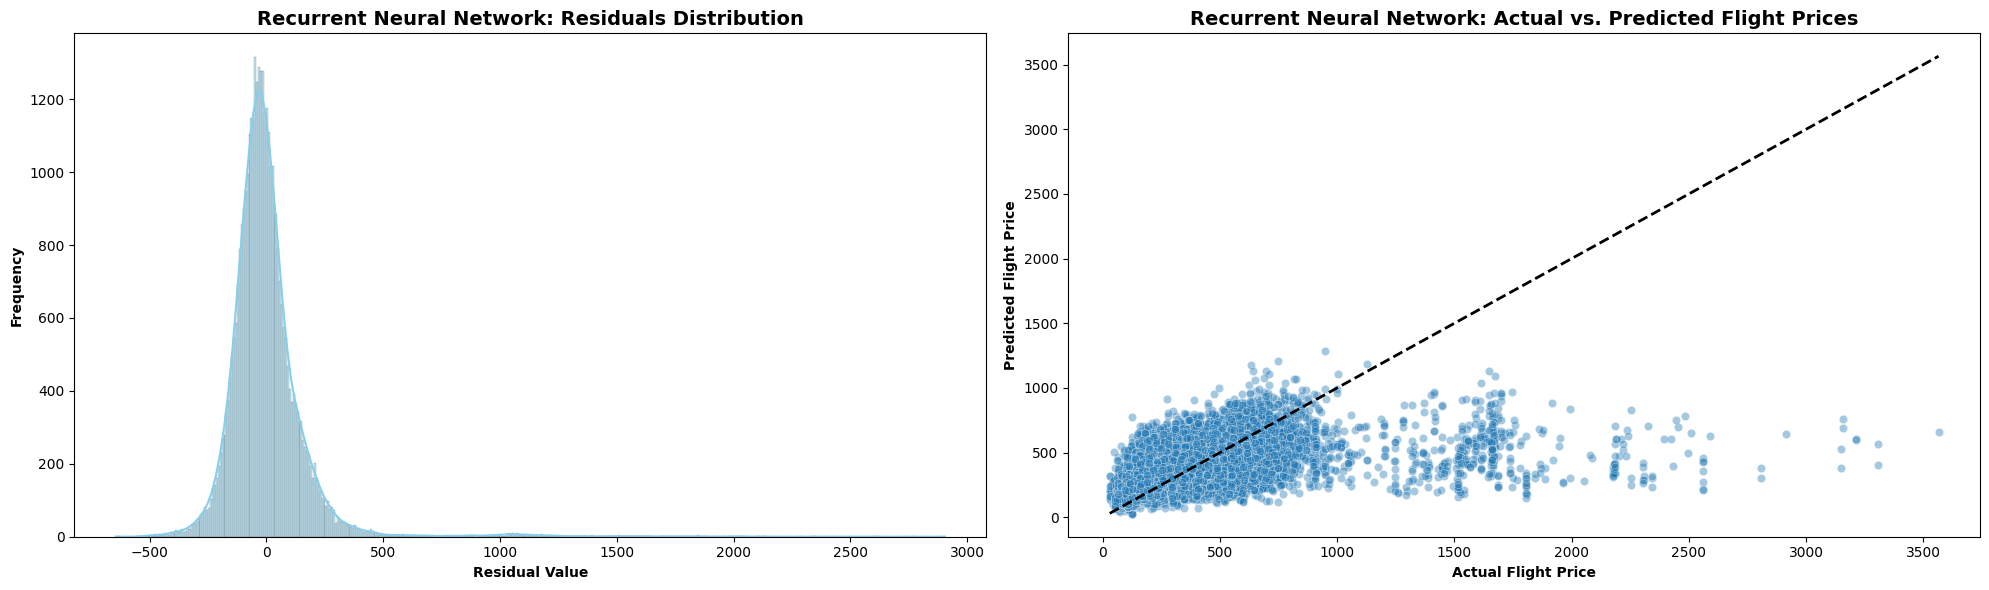

In [152]:
plot_residuals(lstm_y_pred.flatten(), lstm_y_test.flatten(), "Recurrent Neural Network")

# Results Comparison

In [ ]:
model_metrics =[ 
    dt_metrics,
    rf_metrics,
    xgb_metrics,
    # rnn_metrics,
    # lstm_metrics
]
df_results = pd.DataFrame(model_metrics)
df_results

,Model,MAE,RMSE,MAPE,R²
0,Decision Tree,64.512736,114.208921,0.230578,0.655604
1,Random Forest,58.643157,105.051004,0.206098,0.708621
2,XG Boost,56.795429,104.488284,0.197109,0.711734


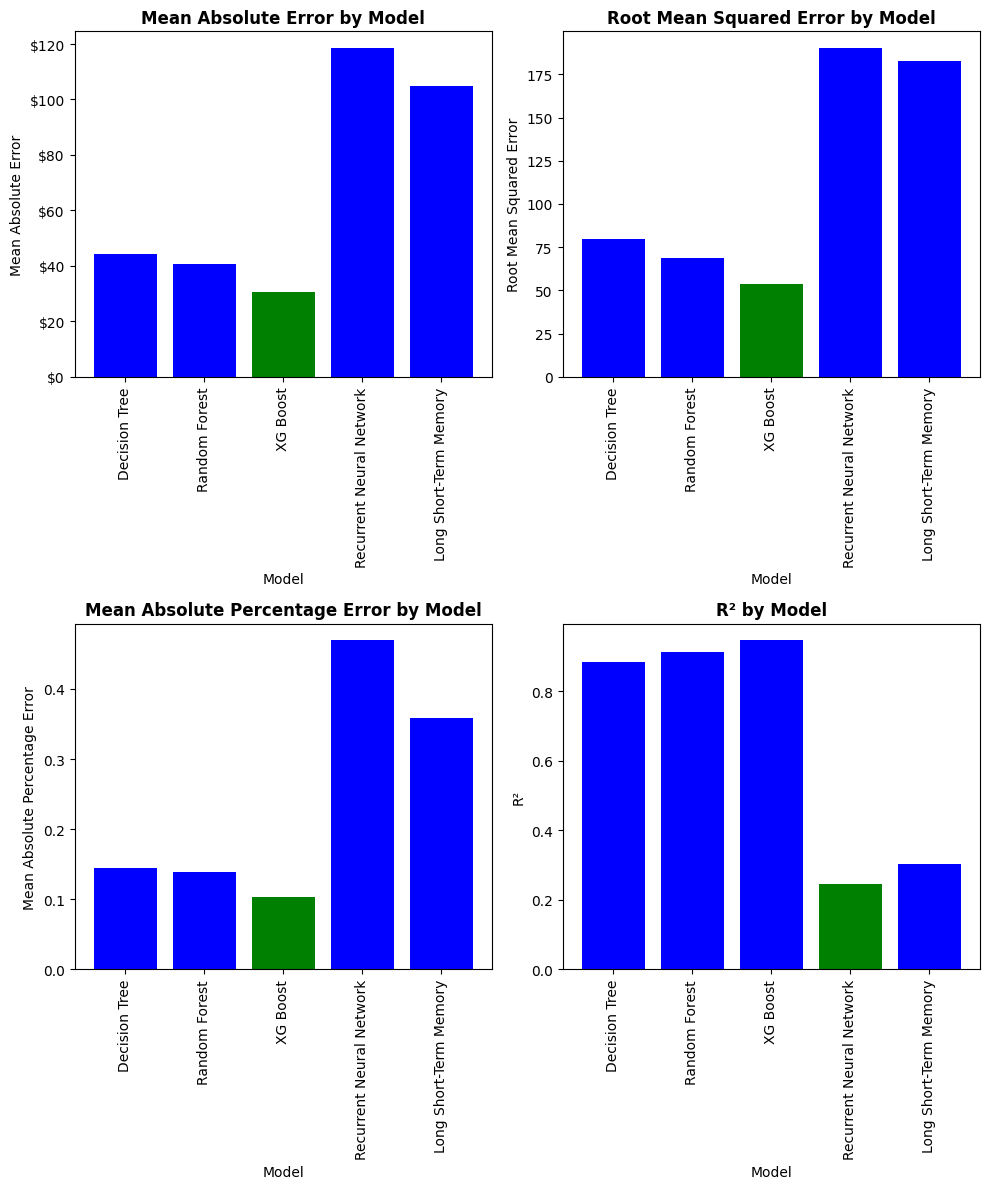

In [154]:
labels = [
    'Mean Absolute Error',
    'Root Mean Squared Error',
    'Mean Absolute Percentage Error',
    'R²'
]
plot_metrics(df_results, df_results.columns[1:], labels= labels)

***INSERT TEXTUAL ANALYSIS HERE***